In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
import matplotlib as mpl
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
fs=14
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

## Load data and matched model output

In [2]:
modSourceDir1= '/results/SalishSea/nowcast-green.201812/'
modSourceDir2= '/results2/SalishSea/nowcast-green.201905/'
modver1='201812'
modver2='201905'
Chl_N=1.8 # Chl:N ratio
startYMD=(2015,1,1)
endYMD=(2017,12,31)

In [3]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [6]:
flist=['/data/sallen/results/MEOPAR/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
       '/data/sallen/results/MEOPAR/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv',
       '/data/sallen/results/MEOPAR/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv']
dlist=list()
for ff in flist:
    dlist.append(pd.read_csv(ff))
data3=pd.concat(dlist,ignore_index=True,sort=True)

In [7]:
data3.keys()

Index(['CT', 'Chlorophyll:Extracted [mg/m^3]', 'Cryptophytes', 'Cyanobacteria',
       'Diatoms-1', 'Diatoms-2', 'Dictyochophytes', 'Dinoflagellates',
       'Fluorescence:URU [mg/m^3]', 'Haptophytes', 'Lat', 'Lon',
       'Nitrate_plus_Nitrite [umol/L]', 'Prasinophytes', 'Raphidophytes', 'SA',
       'Sample_Number', 'Silicate [umol/L]', 'TchlA (ug/L)', 'Unnamed: 0', 'Z',
       'dtUTC', 'i', 'j', 'k', 'mod_ammonium', 'mod_ciliates', 'mod_diatoms',
       'mod_flagellates', 'mod_nitrate', 'mod_silicon', 'mod_vosaline',
       'mod_votemper', 'p'],
      dtype='object')

In [8]:
data0=data3.drop(columns=['Unnamed: 0','mod_ammonium', 'mod_ciliates', 'mod_diatoms',
       'mod_flagellates', 'mod_nitrate', 'mod_silicon', 'mod_vosaline',
       'mod_votemper'])
data0['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in data0['dtUTC']]

In [9]:

data3['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in data3['dtUTC']]

In [10]:
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}
rematch=False
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/'
fname1=f'dataHPLC_{modver1}_{start_date.strftime("%Y%m%d")}_{start_date.strftime("%Y%m%d")}.pkl'
fname2=f'dataHPLC_{modver2}_{start_date.strftime("%Y%m%d")}_{start_date.strftime("%Y%m%d")}.pkl'
if rematch==True:
    data1=et.matchData(data0,filemap,fdict,start_date,end_date,namfmt,modSourceDir1,flen,preIndexed=True)
    data2=et.matchData(data0,filemap,fdict,start_date,end_date,namfmt,modSourceDir2,flen,preIndexed=True)
    pickle.dump(data1,open(os.path.join(saveloc,fname1),'wb'))
    pickle.dump(data2,open(os.path.join(saveloc,fname2),'wb'))
else:
    data1=pickle.load(open(os.path.join(saveloc,fname1),'rb'))
    data2=pickle.load(open(os.path.join(saveloc,fname2),'rb'))

In [11]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

In [12]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data3['yd']=yd(data3['dtUTC'])
data3['Year']=[ii.year for ii in data3['dtUTC']]
data2['yd']=yd(data2['dtUTC'])
data2['Year']=[ii.year for ii in data2['dtUTC']]
data1['yd']=yd(data1['dtUTC'])
data1['Year']=[ii.year for ii in data1['dtUTC']]

Text(0.5, 0.355, '202007')

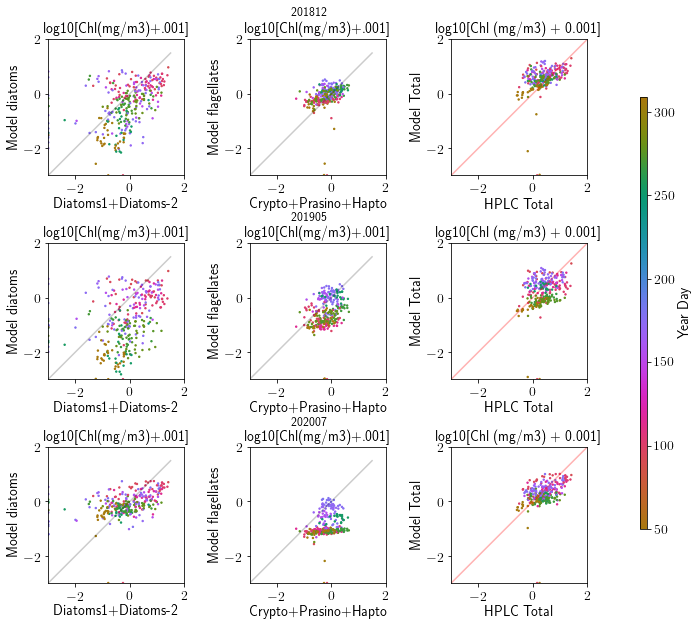

In [13]:
# total chlorophyll comparisons
ms=2

fig,ax=plt.subplots(3,3,figsize=(10,10))
fig.subplots_adjust(hspace=.5,wspace=.3)
cx=fig.add_axes([.96,.2,.01,.6])
#m=ax[0].scatter(data1['TchlA (ug/L)'],Chl_N*(data1['mod_flagellates']+data1['mod_ciliates']+data1['mod_diatoms']),
#          c=data1['yd'],s=5,cmap=cmocean.cm.phase)
ax[0,0].scatter(logt(data1['Diatoms-1']+data1['Diatoms-2']),logt(data1['mod_diatoms']),c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
ax[0,0].set_ylabel('Model diatoms')
ax[0,0].set_xlabel('Diatoms1+Diatoms-2')
ax[0,0].set_title('log10[Chl(mg/m3)+.001]')
ax[0,0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0,0].set_xlim((-3,2))
ax[0,0].set_ylim((-3,2))
ax[0,0].set_aspect(1)

ax[0,1].scatter(logt(data1['Cryptophytes']+data1['Prasinophytes']+data1['Haptophytes']),logt(data1['mod_flagellates']),
                c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
ax[0,1].set_ylabel('Model flagellates')
ax[0,1].set_xlabel('Crypto+Prasino+Hapto')
ax[0,1].set_title('log10[Chl(mg/m3)+.001]')
ax[0,1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0,1].set_xlim((-3,2))
ax[0,1].set_ylim((-3,2))
ax[0,1].set_aspect(1)

m=ax[0,2].scatter(logt(data1['TchlA (ug/L)']),logt(Chl_N*(data1['mod_flagellates']+data1['mod_ciliates']+data1['mod_diatoms'])),
          c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
ax[0,2].set_title('log10[Chl (mg/m3) + 0.001]')
ax[0,2].set_xlabel('HPLC Total')
ax[0,2].set_ylabel('Model Total')
ax[0,2].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[0,2].set_xlim(-3,2)
ax[0,2].set_ylim(-3,2);
ax[0,2].set_aspect(1)
#cb=fig.colorbar(m,ax=ax[0,2])
#cb.set_label('Year Day')

ax[1,0].scatter(logt(data2['Diatoms-1']+data2['Diatoms-2']),logt(data2['mod_diatoms']),c=data2['yd'],
                s=ms,cmap=cmocean.cm.phase)
ax[1,0].set_ylabel('Model diatoms')
ax[1,0].set_xlabel('Diatoms1+Diatoms-2')
ax[1,0].set_title('log10[Chl(mg/m3)+.001]')
ax[1,0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1,0].set_xlim((-3,2))
ax[1,0].set_ylim((-3,2))
ax[1,0].set_aspect(1)

ax[1,1].scatter(logt(data2['Cryptophytes']+data2['Prasinophytes']+data2['Haptophytes']),logt(data2['mod_flagellates']),
                c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
ax[1,1].set_ylabel('Model flagellates')
ax[1,1].set_xlabel('Crypto+Prasino+Hapto')
ax[1,1].set_title('log10[Chl(mg/m3)+.001]')
ax[1,1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1,1].set_xlim((-3,2))
ax[1,1].set_ylim((-3,2))
ax[1,1].set_aspect(1)

m=ax[1,2].scatter(logt(data2['TchlA (ug/L)']),logt(Chl_N*(data2['mod_flagellates']+data2['mod_ciliates']+data2['mod_diatoms'])),
          c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
ax[1,2].set_title('log10[Chl (mg/m3) + 0.001]')
ax[1,2].set_xlabel('HPLC Total')
ax[1,2].set_ylabel('Model Total')
ax[1,2].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1,2].set_xlim(-3,2)
ax[1,2].set_ylim(-3,2);
ax[1,2].set_aspect(1)
#cb=fig.colorbar(m,ax=ax[1,2])
#cb.set_label('Year Day')

ax[2,0].scatter(logt(data3['Diatoms-1']+data3['Diatoms-2']),logt(data3['mod_diatoms']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
ax[2,0].set_ylabel('Model diatoms')
ax[2,0].set_xlabel('Diatoms1+Diatoms-2')
ax[2,0].set_title('log10[Chl(mg/m3)+.001]')
ax[2,0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2,0].set_xlim((-3,2))
ax[2,0].set_ylim((-3,2))
ax[2,0].set_aspect(1)

ax[2,1].scatter(logt(data3['Cryptophytes']+data3['Prasinophytes']+data3['Haptophytes']),logt(data3['mod_flagellates']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
ax[2,1].set_ylabel('Model flagellates')
ax[2,1].set_xlabel('Crypto+Prasino+Hapto')
ax[2,1].set_title('log10[Chl(mg/m3)+.001]')
ax[2,1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2,1].set_xlim((-3,2))
ax[2,1].set_ylim((-3,2))
ax[2,1].set_aspect(1)

m=ax[2,2].scatter(logt(data3['TchlA (ug/L)']),logt(Chl_N*(data3['mod_flagellates']+data3['mod_ciliates']+data3['mod_diatoms'])),
          c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
ax[2,2].set_title('log10[Chl (mg/m3) + 0.001]')
ax[2,2].set_xlabel('HPLC Total')
ax[2,2].set_ylabel('Model Total')
ax[2,2].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[2,2].set_xlim(-3,2)
ax[2,2].set_ylim(-3,2);
ax[2,2].set_aspect(1)
cb=fig.colorbar(m,cax=cx)
cb.set_label('Year Day')

plt.text(0.5, .925, '201812',ha='center', va='top',transform=fig.transFigure,fontsize=12)
plt.text(0.5, .64, '201905',ha='center', va='top',transform=fig.transFigure,fontsize=12)
plt.text(0.5, .355, '202007',ha='center', va='top',transform=fig.transFigure,fontsize=12)

#fig.savefig('EGUHPLC.png',dpi=100,bbox_inches='tight')

Text(0.5, 0.925, 'log10[Chl (mg/m3) + 0.001]')

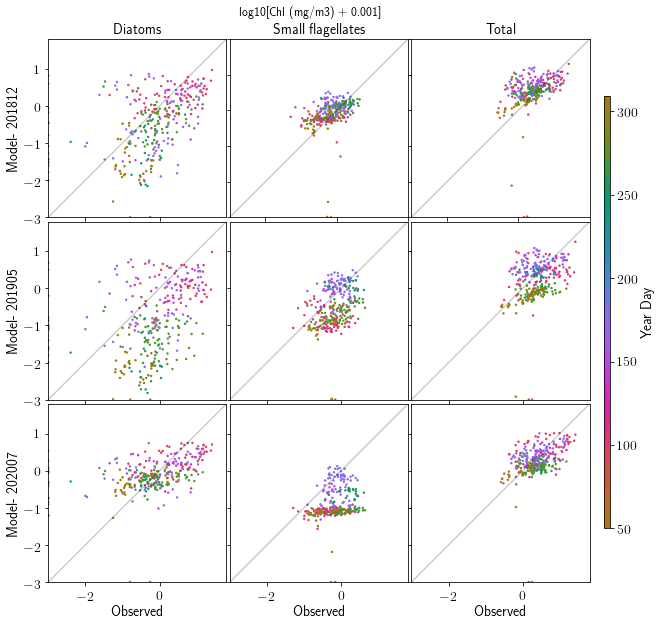

In [14]:
# total chlorophyll comparisons v2
ms=2
lims=(-3,1.8)

fig,ax=plt.subplots(3,3,figsize=(9.7,10))
fig.subplots_adjust(hspace=0.02,wspace=0.02)
cx=fig.add_axes([.92,.2,.01,.6])

iax=ax[0,0]
iax.scatter(logt(data1['Diatoms-1']+data1['Diatoms-2']),logt(data1['mod_diatoms']),c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Model- 201812')
iax.set_title('Diatoms')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])

iax=ax[0,1]
iax.scatter(logt(data1['Cryptophytes']+data1['Prasinophytes']+data1['Haptophytes']),logt(data1['mod_flagellates']),
                c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_title('Small flagellates')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim((-3,2))
iax.set_ylim((-3,2))
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[0,2]
iax.scatter(logt(data1['TchlA (ug/L)']),logt(Chl_N*(data1['mod_flagellates']+data1['mod_ciliates']+data1['mod_diatoms'])),
          c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_title('Total')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(-3,2)
iax.set_ylim(-3,2);
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[1,0]
iax.scatter(logt(data2['Diatoms-1']+data2['Diatoms-2']),logt(data2['mod_diatoms']),c=data2['yd'],
                s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Model- 201905')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])

iax=ax[1,1]
iax.scatter(logt(data2['Cryptophytes']+data2['Prasinophytes']+data2['Haptophytes']),logt(data2['mod_flagellates']),
                c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[1,2]
iax.scatter(logt(data2['TchlA (ug/L)']),logt(Chl_N*(data2['mod_flagellates']+data2['mod_ciliates']+data2['mod_diatoms'])),
          c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[2,0]
iax.scatter(logt(data3['Diatoms-1']+data3['Diatoms-2']),logt(data3['mod_diatoms']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Model- 202007')
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)

iax=ax[2,1]
iax.scatter(logt(data3['Cryptophytes']+data3['Prasinophytes']+data3['Haptophytes']),logt(data3['mod_flagellates']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)
iax.set_yticklabels([])

iax=ax[2,2]
m=iax.scatter(logt(data3['TchlA (ug/L)']),logt(Chl_N*(data3['mod_flagellates']+data3['mod_ciliates']+data3['mod_diatoms'])),
          c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
cb=fig.colorbar(m,cax=cx)
cb.set_label('Year Day')
iax.set_yticklabels([])

plt.text(0.5, .925, 'log10[Chl (mg/m3) + 0.001]',ha='center', va='top',transform=fig.transFigure,fontsize=12)
#fig.savefig('EGUHPLC.png',dpi=100,bbox_inches='tight')

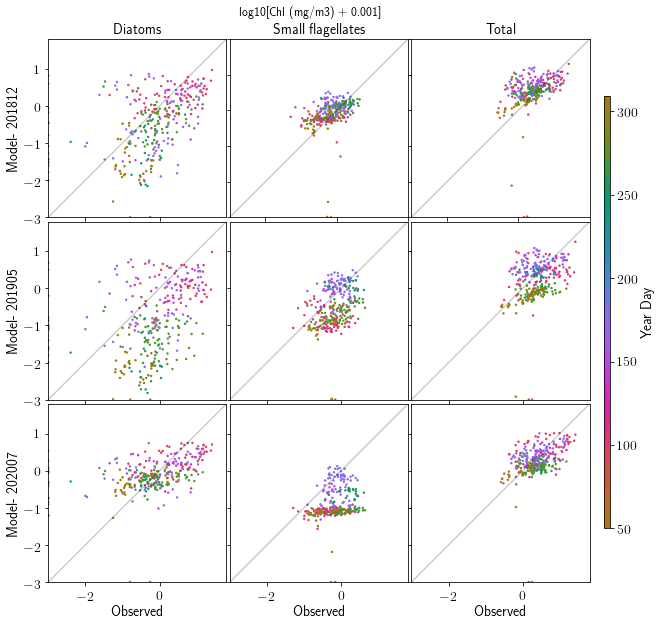

In [15]:
# total chlorophyll comparisons v2
ms=2
lims=(-3,1.8)

fig,ax=plt.subplots(3,3,figsize=(9.7,10))
fig.subplots_adjust(hspace=0.02,wspace=0.02)
cx=fig.add_axes([.92,.2,.01,.6])

iax=ax[0,0]
iax.scatter(logt(data1['Diatoms-1']+data1['Diatoms-2']),logt(data1['mod_diatoms']),c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Model- 201812')
iax.set_title('Diatoms')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])

iax=ax[0,1]
iax.scatter(logt(data1['Cryptophytes']+data1['Prasinophytes']+data1['Haptophytes']),logt(data1['mod_flagellates']),
                c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_title('Small flagellates')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim((-3,2))
iax.set_ylim((-3,2))
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[0,2]
iax.scatter(logt(data1['TchlA (ug/L)']),logt(Chl_N*(data1['mod_flagellates']+data1['mod_ciliates']+data1['mod_diatoms'])),
          c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_title('Total')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(-3,2)
iax.set_ylim(-3,2);
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[1,0]
iax.scatter(logt(data2['Diatoms-1']+data2['Diatoms-2']),logt(data2['mod_diatoms']),c=data2['yd'],
                s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Model- 201905')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])

iax=ax[1,1]
iax.scatter(logt(data2['Cryptophytes']+data2['Prasinophytes']+data2['Haptophytes']),logt(data2['mod_flagellates']),
                c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[1,2]
iax.scatter(logt(data2['TchlA (ug/L)']),logt(Chl_N*(data2['mod_flagellates']+data2['mod_ciliates']+data2['mod_diatoms'])),
          c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[2,0]
iax.scatter(logt(data3['Diatoms-1']+data3['Diatoms-2']),logt(data3['mod_diatoms']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Model- 202007')
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)

iax=ax[2,1]
iax.scatter(logt(data3['Cryptophytes']+data3['Prasinophytes']+data3['Haptophytes']),logt(data3['mod_flagellates']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)
iax.set_yticklabels([])

iax=ax[2,2]
m=iax.scatter(logt(data3['TchlA (ug/L)']),logt(Chl_N*(data3['mod_flagellates']+data3['mod_ciliates']+data3['mod_diatoms'])),
          c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
cb=fig.colorbar(m,cax=cx)
cb.set_label('Year Day')
iax.set_yticklabels([])

plt.text(0.5, .925, 'log10[Chl (mg/m3) + 0.001]',ha='center', va='top',transform=fig.transFigure,fontsize=12)
fig.savefig('EGUHPLC.png',dpi=100,bbox_inches='tight')

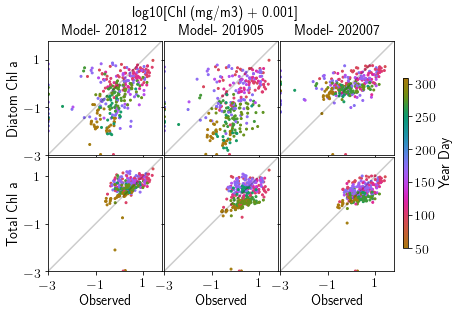

In [24]:
# total chlorophyll comparisons v2
ms=4
lims=(-3,1.8)
ticks=[-3,-1,1]

fig,ax=plt.subplots(2,3,figsize=(6.2,4.3))
fig.subplots_adjust(hspace=0.02,wspace=0.02,top=.87)
cx=fig.add_axes([.92,.2,.01,.55])

iax=ax[0,0]
iax.scatter(logt(data1['Diatoms-1']+data1['Diatoms-2']),logt(data1['mod_diatoms']),c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Diatom Chl a')
iax.set_title('Model- 201812')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xticks(ticks)
iax.set_yticks(ticks)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticklabels([])

iax=ax[1,0]
iax.scatter(logt(data1['TchlA (ug/L)']),logt(Chl_N*(data1['mod_flagellates']+data1['mod_ciliates']+data1['mod_diatoms'])),
          c=data1['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_ylabel('Total Chl a')
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xticks(ticks)
iax.set_yticks(ticks)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)

iax=ax[0,1]
iax.scatter(logt(data2['Diatoms-1']+data2['Diatoms-2']),logt(data2['mod_diatoms']),c=data2['yd'],
                s=ms,cmap=cmocean.cm.phase)
iax.set_title('Model- 201905')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_xticks(ticks)
iax.set_yticks(ticks)
iax.set_xticklabels([])
iax.set_yticklabels([])

iax=ax[1,1]
iax.scatter(logt(data2['TchlA (ug/L)']),logt(Chl_N*(data2['mod_flagellates']+data2['mod_ciliates']+data2['mod_diatoms'])),
          c=data2['yd'],s=ms,cmap=cmocean.cm.phase)
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlabel('Observed')
iax.set_xticks(ticks)
iax.set_yticks(ticks)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)
iax.set_yticklabels([])

iax=ax[0,2]
iax.scatter(logt(data3['Diatoms-1']+data3['Diatoms-2']),logt(data3['mod_diatoms']),
                c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_title('Model- 202007')
#iax.set_xlabel('Observed')
iax.set_xticks(ticks)
iax.set_yticks(ticks)
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xlim(lims)
iax.set_ylim(lims);
iax.set_aspect(1)
iax.set_yticklabels([])
iax.set_xticklabels([])


iax=ax[1,2]
m=iax.scatter(logt(data3['TchlA (ug/L)']),logt(Chl_N*(data3['mod_flagellates']+data3['mod_ciliates']+data3['mod_diatoms'])),
          c=data3['yd'],s=ms,cmap=cmocean.cm.phase)
iax.set_xlabel('Observed')
iax.plot((-6,5),(-6,5),'k-',alpha=.2)
iax.set_xticks(ticks)
iax.set_yticks(ticks)
iax.set_xlim(lims)
iax.set_ylim(lims)
iax.set_aspect(1)
iax.set_yticklabels([])
cb=fig.colorbar(m,cax=cx)
cb.set_label('Year Day')

plt.text(0.5, .98, 'log10[Chl (mg/m3) + 0.001]',ha='center', va='top',transform=fig.transFigure,fontsize=14)
fig.savefig('EGUHPLC.png',dpi=100,bbox_inches='tight')